In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, 
                            confusion_matrix, classification_report)
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lightgbm import LGBMClassifier
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install wheel numpy cython


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-surprise==1.1.1  

  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp39-cp39-win_amd64.whl size=715670 sha256=1cee5c4efd3a5ca5689b7b08de3182cda7109a086ade4837b003e4cf5a5fada7
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\6b\10\c9\7f607c8cb522ef378844f41e63b30d7181a6495d2c1ae514e9
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [8]:

# Load the dataset
df = pd.read_csv('cleaned_merged_ieee_bank.csv')


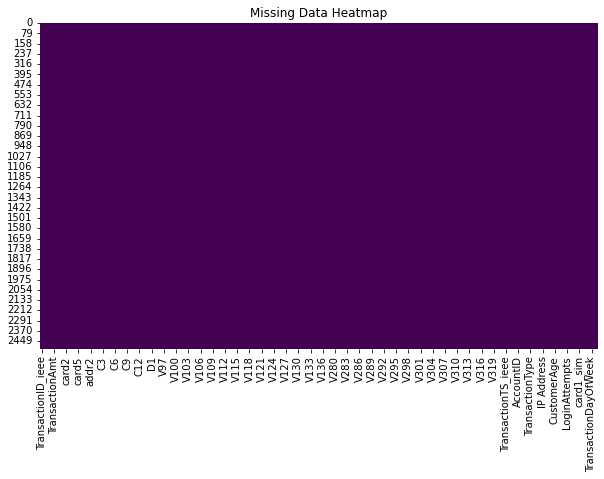

In [16]:
# Create a missing data visualization
plt.figure(figsize=(10, 6))

# Heatmap of missing data
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

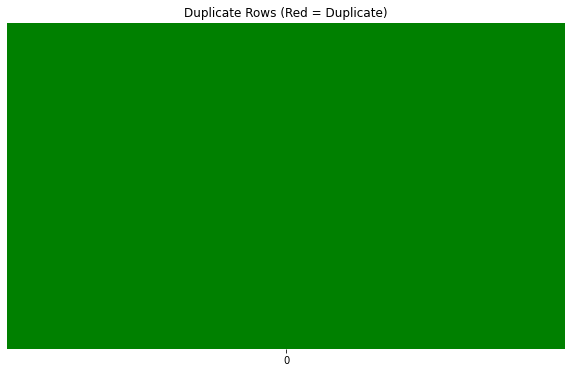

In [14]:
# 1. Visualize duplicate rows
duplicate_rows = df.duplicated(keep=False)
plt.figure(figsize=(10, 6))
sns.heatmap(duplicate_rows.to_frame(), cbar=False, cmap=['green', 'red'])
plt.title('Duplicate Rows (Red = Duplicate)')
plt.yticks([])
plt.show()

In [15]:
# Replace missing values with mode for each column
for column in df.columns:
    if df[column].isnull().any():
        mode_value = df[column].mode()[0]  # Get first mode if multiple exist
        df[column].fillna(mode_value, inplace=True)

In [17]:


# Data Preparation
def prepare_data(df):
    # Convert datetime columns
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
    
    # Feature engineering
    df['TransactionHour'] = df['TransactionDate'].dt.hour
    df['TransactionDayOfWeek'] = df['TransactionDate'].dt.dayofweek
    df['DaysSinceLastTransaction'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.days
    
    # Encode categorical variables
    cat_cols = ['ProductCD', 'card4', 'card6', 'TransactionType', 'Location', 
                'Channel', 'CustomerOccupation', 'CustomerAge']
    for col in cat_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # Select relevant features
    features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
                'C11', 'C12', 'C13', 'C14', 'D1', 'TransactionHour', 'TransactionDayOfWeek',
                'TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance',
                'DaysSinceLastTransaction', 'CustomerAge', 'CustomerOccupation']
    
    # Only keep features that exist in the dataframe
    features = [f for f in features if f in df.columns]
    
    X = df[features]
    y = df['isFraud']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test

X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test = prepare_data(df)

In [18]:


# 🔐 Fraud Detection Models

def supervised_fraud_detection(X_train, X_test, y_train, y_test):
    print("\n🔐 Supervised Fraud Detection (LightGBM)")
    
    # Train LightGBM model
    lgbm = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        class_weight='balanced'
    )
    
    lgbm.fit(X_train, y_train)
    
    # Predictions
    y_pred = lgbm.predict(X_test)
    y_prob = lgbm.predict_proba(X_test)[:, 1]
    
    # Evaluation
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'], 
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title('Confusion Matrix - LightGBM')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Feature Importance
    feature_imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': lgbm.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
    plt.title('Top 15 Important Features - LightGBM')
    plt.tight_layout()
    plt.show()
    
    return lgbm

In [19]:


def unsupervised_fraud_detection(X_train_scaled, X_test_scaled, y_test):
    print("\n🔐 Unsupervised Fraud Detection (Isolation Forest)")
    
    # Train Isolation Forest
    iso_forest = IsolationForest(
        n_estimators=200,
        max_samples='auto',
        contamination='auto',
        max_features=1.0,
        random_state=42
    )
    
    iso_forest.fit(X_train_scaled)
    
    # Predict anomalies (1 for normal, -1 for anomaly)
    y_pred_iso = iso_forest.predict(X_test_scaled)
    
    # Convert to binary (0 for normal, 1 for anomaly)
    y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
    
    # Since we have labels, we can evaluate
    if y_test.nunique() > 1:  # Only if we have both classes
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_iso):.4f}")
        print(f"F1 Score: {f1_score(y_test, y_pred_iso):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred_iso):.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_iso)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Fraud', 'Fraud'], 
                    yticklabels=['Not Fraud', 'Fraud'])
        plt.title('Confusion Matrix - Isolation Forest')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
    else:
        print("No fraud cases in test set to evaluate")
    
    return iso_forest


🔐 Supervised Fraud Detection (LightGBM)
[LightGBM] [Info] Number of positive: 36, number of negative: 1722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 1758, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC Score: 0.7962
F1 Score: 0.4000
Precision: 1.0000


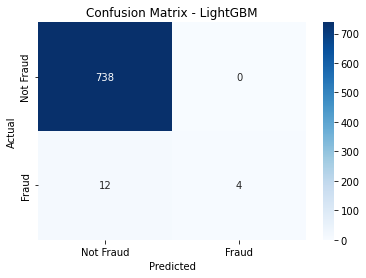

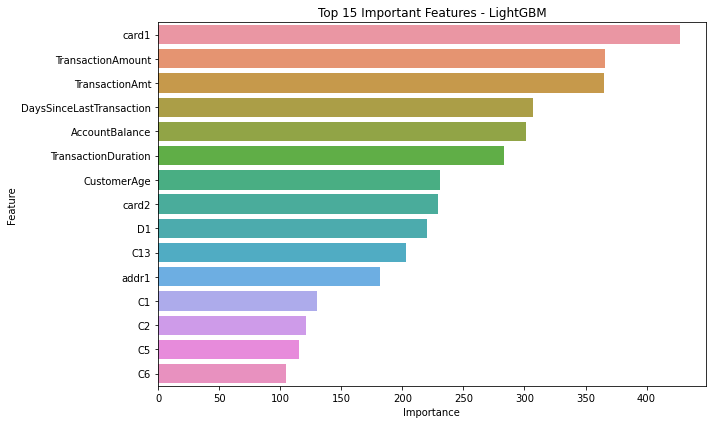


🔐 Unsupervised Fraud Detection (Isolation Forest)
ROC-AUC Score: 0.4967
F1 Score: 0.0294
Precision: 0.0192


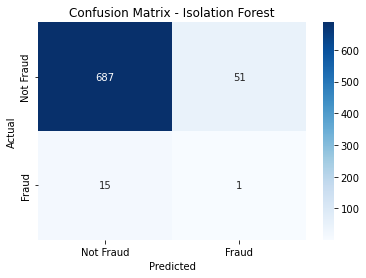

In [20]:

# Run fraud detection models
lgbm_model = supervised_fraud_detection(X_train, X_test, y_train, y_test)
iso_model = unsupervised_fraud_detection(X_train_scaled, X_test_scaled, y_test)

In [21]:



# 🤝 Customer Recommendation Systems

def collaborative_filtering_recommendations(df):
    print("\n🤝 Collaborative Filtering Recommendations (SVD)")
    
    # Prepare data for Surprise library
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        df[['AccountID', 'MerchantID', 'TransactionAmount']], reader)
    
    # Build SVD model
    svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
    
    # Cross-validation
    cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    # Train on full dataset
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    
    # Example: Get top recommendations for a customer
    def get_top_recommendations(account_id, n=5):
        all_merchants = df['MerchantID'].unique()
        predictions = []
        for merchant in all_merchants:
            pred = svd.predict(account_id, merchant)
            predictions.append((merchant, pred.est))
        
        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]
    
    # Test with a sample customer
    sample_customer = df['AccountID'].iloc[0]
    print(f"\nTop 5 merchant recommendations for customer {sample_customer}:")
    top_recs = get_top_recommendations(sample_customer)
    for merchant, score in top_recs:
        print(f"Merchant: {merchant}, Predicted Rating: {score:.4f}")
    
    return svd

def content_based_recommendations(df):
    print("\n🤝 Content-Based Recommendations (KNN)")
    
    # Create customer profiles
    customer_profiles = df.groupby('AccountID').agg({
        'TransactionAmount': ['mean', 'count', 'sum'],
        'TransactionDuration': 'mean',
        'CustomerAge': 'first',
        'CustomerOccupation': 'first',
        'Location': lambda x: x.mode()[0]
    }).reset_index()
    
    customer_profiles.columns = [
        'AccountID', 'AvgAmount', 'TransactionCount', 'TotalAmount',
        'AvgDuration', 'Age', 'Occupation', 'PreferredLocation'
    ]
    
    # One-hot encode categorical features
    customer_profiles = pd.get_dummies(
        customer_profiles, 
        columns=['Occupation', 'PreferredLocation']
    )
    
    # Normalize features
    scaler = StandardScaler()
    features = customer_profiles.drop('AccountID', axis=1).columns
    customer_profiles[features] = scaler.fit_transform(customer_profiles[features])
    
    # Build KNN model
    knn = NearestNeighbors(n_neighbors=5, metric='cosine')
    knn.fit(customer_profiles.drop('AccountID', axis=1))
    
    # Example: Find similar customers
    def find_similar_customers(account_id, n=5):
        customer_idx = customer_profiles[customer_profiles['AccountID'] == account_id].index[0]
        customer_data = customer_profiles.iloc[customer_idx, 1:].values.reshape(1, -1)
        
        distances, indices = knn.kneighbors(customer_data, n_neighbors=n+1)
        
        # Exclude the customer themselves
        similar_customers = customer_profiles.iloc[indices[0][1:], 0]
        similarity_scores = 1 - distances[0][1:]
        
        return list(zip(similar_customers, similarity_scores))
    
    # Test with a sample customer
    sample_customer = df['AccountID'].iloc[0]
    print(f"\nMost similar customers to {sample_customer}:")
    similar_customers = find_similar_customers(sample_customer)
    for customer, similarity in similar_customers:
        print(f"Customer: {customer}, Similarity: {similarity:.4f}")
    
    return knn, customer_profiles

In [22]:
# Run recommendation systems
svd_model = collaborative_filtering_recommendations(df)
knn_model, customer_profiles = content_based_recommendations(df)


🤝 Collaborative Filtering Recommendations (SVD)
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    409.2357432.3586407.5385405.3056425.4980415.987310.8585 
MAE (testset)     291.5173309.9741287.7145291.7124302.0431296.59238.2118  
Fit time          0.07    0.12    0.09    0.07    0.07    0.08    0.02    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    

Top 5 merchant recommendations for customer AC00499:
Merchant: M086, Predicted Rating: 1.0000
Merchant: M059, Predicted Rating: 1.0000
Merchant: M089, Predicted Rating: 1.0000
Merchant: M011, Predicted Rating: 1.0000
Merchant: M007, Predicted Rating: 1.0000

🤝 Content-Based Recommendations (KNN)

Most similar customers to AC00499:
Customer: AC00010, Similarity: 0.9702
Customer: AC00200, Similarity: 0.9438
Customer: AC00144, Similarity: 0.9182
Customer: AC00133, Similarity: 0.9014
Customer: AC00009, Similarity: 0.885

In [23]:


# 📊 Customer Insights & Segmentation

def customer_segmentation(df):
    print("\n📊 Customer Segmentation (KMeans + PCA)")
    
    # RFM Analysis
    current_date = df['TransactionDate'].max() + pd.Timedelta(days=1)
    
    rfm = df.groupby('AccountID').agg({
        'TransactionDate': lambda x: (current_date - x.max()).days,  # Recency
        'TransactionID_bank': 'count',  # Frequency
        'TransactionAmount': 'sum'      # Monetary
    }).reset_index()
    
    rfm.columns = ['AccountID', 'Recency', 'Frequency', 'Monetary']
    
    # RFM Scoring (lower recency is better, higher frequency/monetary is better)
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)
    
    # RFM Segments
    def get_rfm_segment(row):
        if row['RFM_Score'] >= 12:
            return 'Champions'
        elif row['RFM_Score'] >= 9:
            return 'Loyal'
        elif row['RFM_Score'] >= 6:
            return 'Potential'
        elif row['RFM_Score'] >= 4:
            return 'At Risk'
        else:
            return 'Lost'
    
    rfm['Segment'] = rfm.apply(get_rfm_segment, axis=1)
    
    # Plot RFM segments
    plt.figure(figsize=(8, 5))
    rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Customer Segments by RFM Score')
    plt.xlabel('Segment')
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=45)
    plt.show()
    
    # KMeans Clustering
    # Prepare data (log transform monetary and frequency to handle skewness)
    clustering_data = rfm[['Recency', 'Frequency', 'Monetary']].copy()
    clustering_data['Frequency'] = np.log1p(clustering_data['Frequency'])
    clustering_data['Monetary'] = np.log1p(clustering_data['Monetary'])
    
    # Standardize
    scaler = StandardScaler()
    clustering_data_scaled = scaler.fit_transform(clustering_data)
    
    # Find optimal number of clusters using elbow method
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(clustering_data_scaled)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    # Based on the elbow, let's choose 4 clusters
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    rfm['Cluster'] = kmeans.labels_
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(clustering_data_scaled)
    
    # Plot clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        pca_result[:, 0], pca_result[:, 1], 
        c=rfm['Cluster'], cmap='viridis', alpha=0.6)
    
    plt.title('Customer Segments Visualization (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Analyze clusters
    cluster_summary = rfm.groupby('Cluster').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'AccountID': 'count'
    }).rename(columns={'AccountID': 'Count'})
    
    print("\nCluster Summary:")
    print(cluster_summary)
    
    return rfm, kmeans, pca


📊 Customer Segmentation (KMeans + PCA)


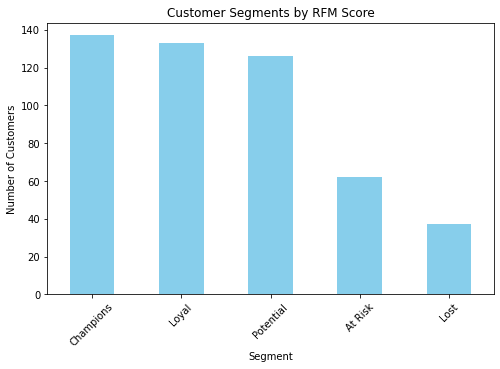

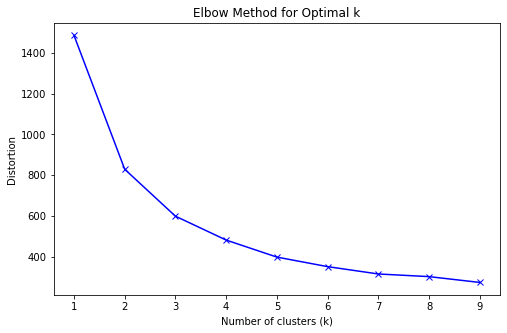

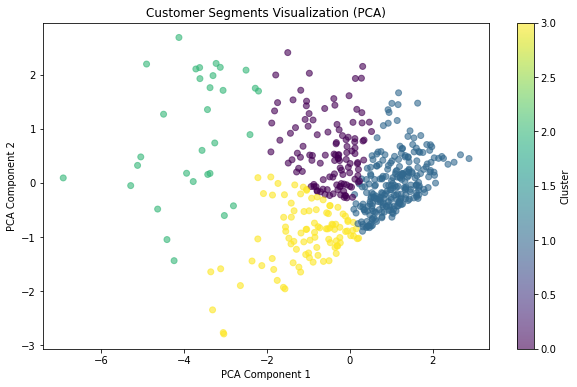


Cluster Summary:
            Recency  Frequency     Monetary  Count
Cluster                                           
0        118.333333   4.299145  1288.783333    117
1         33.108000   6.712000  2113.055360    250
2        250.709677   1.548387   308.667419     31
3         46.371134   2.917526   607.581340     97

✨ Analysis Complete! ✨


In [24]:

# Run customer segmentation
rfm_data, kmeans_model, pca_model = customer_segmentation(df)

print("\n✨ Analysis Complete! ✨")

In [26]:
pip install lz4

Note: you may need to restart the kernel to use updated packages.


In [28]:
from joblib import dump
from datetime import datetime
import os

# Create timestamp and export directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = f"model_exports_{timestamp}"
os.makedirs(export_dir, exist_ok=True)

# 1. Export Fraud Detection Models (No Compression)
dump(lgbm_model, f'{export_dir}/fraud_lgbm.joblib', compress=False)
dump(iso_model, f'{export_dir}/fraud_isolation_forest.joblib', compress=False)

# 2. Export Recommendation Systems (No Compression)
dump(svd_model, f'{export_dir}/recommendation_svd.joblib', compress=False)
dump(knn_model, f'{export_dir}/recommendation_knn.joblib', compress=False)

# 3. Export Customer Segmentation Models (No Compression)
dump(kmeans_model, f'{export_dir}/segmentation_kmeans.joblib', compress=False)
dump(pca_model, f'{export_dir}/segmentation_pca.joblib', compress=False)

# 4. Export Supporting Data (No Compression)
dump(customer_profiles, f'{export_dir}/customer_profiles.joblib', compress=False)
dump(rfm_data, f'{export_dir}/rfm_data.joblib', compress=False)

# 5. Export Metadata (No Compression)
metadata = {
    'export_timestamp': timestamp,
    'models': {
        'fraud_lgbm': 'LightGBM classifier',
        'fraud_isolation_forest': 'Isolation Forest',
        'recommendation_svd': 'SVD recommender',
        'recommendation_knn': 'KNN recommender',
        'segmentation_kmeans': 'KMeans clustering',
        'segmentation_pca': 'PCA transformer'
    }
}
dump(metadata, f'{export_dir}/metadata.joblib', compress=False)

print(f"All models exported to directory: {export_dir}")
print("Files created:")
for f in os.listdir(export_dir):
    print(f"- {f}")

All models exported to directory: model_exports_20250718_124139
Files created:
- customer_profiles.joblib
- fraud_isolation_forest.joblib
- fraud_lgbm.joblib
- metadata.joblib
- recommendation_knn.joblib
- recommendation_svd.joblib
- rfm_data.joblib
- segmentation_kmeans.joblib
- segmentation_pca.joblib
